# 1. Imports

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 2. Loading the dataset

In [8]:
dataset = pd.read_csv("../../data/processed/COEN498-691_HAR_preprocessed_dataset.csv")
df = pd.DataFrame(dataset)

In [16]:
activity_mapper = {
    'sitting': 1,
    'walking': 2,
    'running': 3,
    'lying': 4,
}

# 3. Training Random Forest classifier (all features)
**Train the model using all features in the original dataset and default hyperparameters. Use Leave-One-Subject-Out (LOSO) cross validation.**

## 3.1. Classification report and confusion matrix

Feature columns: ['ax_kurt', 'ax_max', 'ax_mean', 'ax_min', 'ax_range', 'ax_skew', 'ax_std', 'ax_zcr', 'ay_kurt', 'ay_max', 'ay_mean', 'ay_min', 'ay_range', 'ay_skew', 'ay_std', 'ay_zcr', 'az_kurt', 'az_max', 'az_mean', 'az_min', 'az_range', 'az_skew', 'az_std', 'az_zcr', 'corr_axy', 'corr_axz', 'corr_ayz', 'sma']
Results for YL
Accuracy: 0.8955
Classification Report:
              precision    recall  f1-score   support

           1       0.78      0.80      0.79       234
           2       1.00      1.00      1.00       234
           3       1.00      1.00      1.00       245
           4       0.80      0.79      0.80       244

    accuracy                           0.90       957
   macro avg       0.90      0.90      0.90       957
weighted avg       0.90      0.90      0.90       957



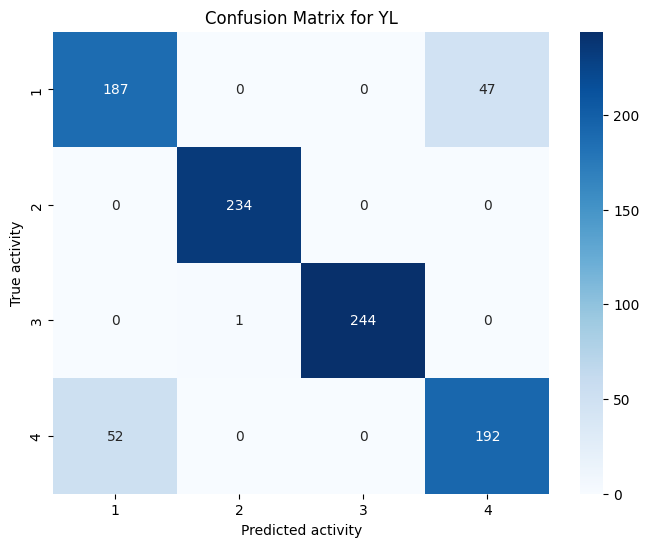

Results for ZM
Accuracy: 0.8008
Classification Report:
              precision    recall  f1-score   support

           1       0.59      0.79      0.68       253
           2       1.00      1.00      1.00       229
           3       1.00      1.00      1.00       234
           4       0.65      0.43      0.52       238

    accuracy                           0.80       954
   macro avg       0.81      0.80      0.80       954
weighted avg       0.81      0.80      0.79       954



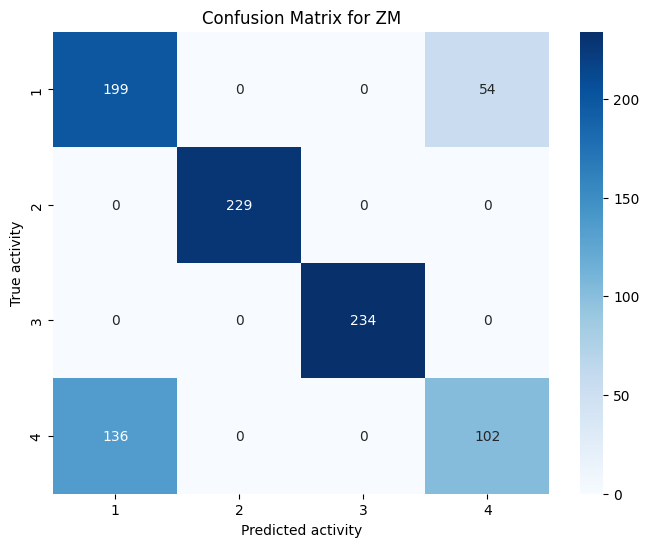

Results for YT
Accuracy: 0.8365
Classification Report:
              precision    recall  f1-score   support

           1       0.62      0.95      0.75       243
           2       1.00      1.00      1.00       237
           3       1.00      1.00      1.00       237
           4       0.89      0.40      0.55       237

    accuracy                           0.84       954
   macro avg       0.88      0.84      0.82       954
weighted avg       0.87      0.84      0.82       954



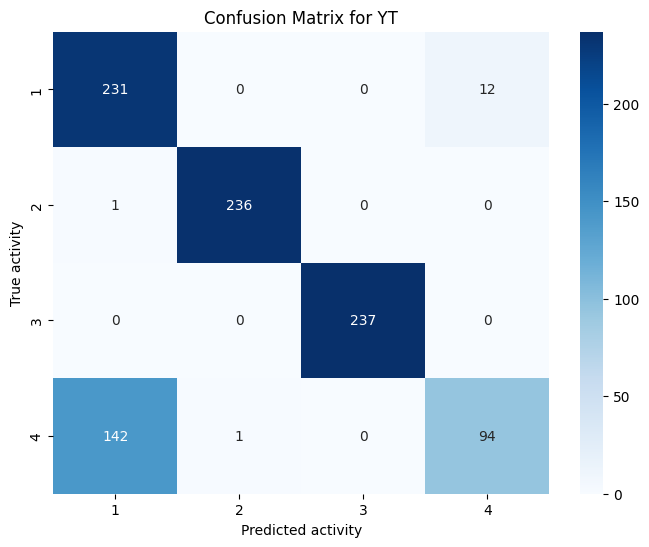

Results for VV
Accuracy: 0.7747
Classification Report:
              precision    recall  f1-score   support

           1       0.53      0.92      0.67       236
           2       1.00      1.00      1.00       235
           3       1.00      1.00      1.00       231
           4       0.74      0.21      0.33       248

    accuracy                           0.77       950
   macro avg       0.82      0.78      0.75       950
weighted avg       0.81      0.77      0.74       950



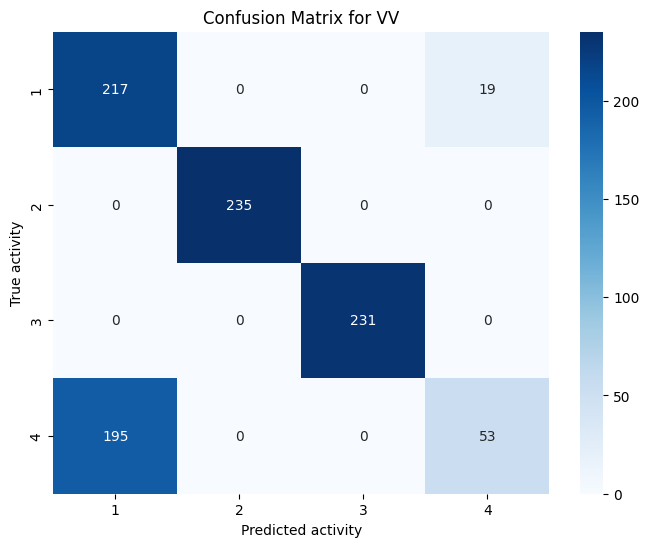

Results for LL
Accuracy: 0.8568
Classification Report:
              precision    recall  f1-score   support

           1       0.68      0.82      0.75       239
           2       0.98      1.00      0.99       231
           3       1.00      1.00      1.00       237
           4       0.78      0.60      0.68       229

    accuracy                           0.86       936
   macro avg       0.86      0.86      0.85       936
weighted avg       0.86      0.86      0.85       936



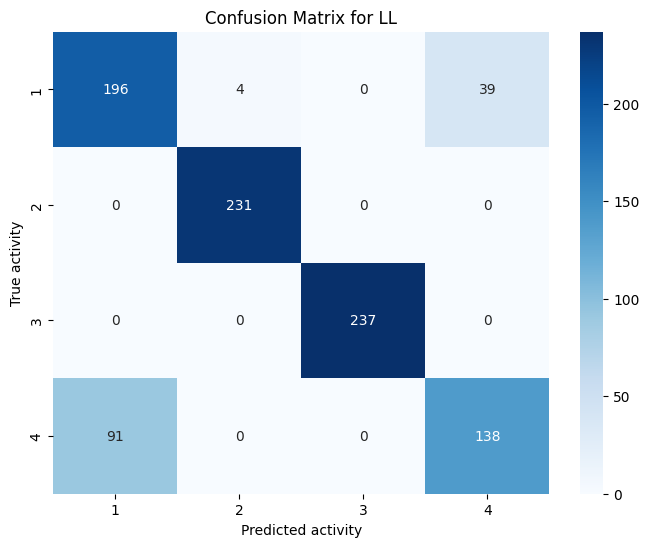

In [ ]:
groups = df['participant_id']
feature_columns = df.columns.difference(['participant_id', 'activity_id', 'timestamp'])
activity_labels = sorted(df['activity_id'].unique())
gkf = GroupKFold(n_splits=5) 
classification_reports = []

for train_index, test_index in gkf.split(df, df['activity_id'], groups):

    train_set = df.iloc[train_index]
    test_set = df.iloc[test_index]

    X_train = train_set[feature_columns]
    y_train = train_set['activity_id']
    X_test = test_set[feature_columns]
    y_test = test_set['activity_id']

    test_participant_id = test_set['participant_id'].iloc[0]


    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)


    y_pred = rf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    classification_reports.append(report)
    print(f"Results for {test_participant_id}")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=activity_labels, columns=activity_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {test_participant_id}')
    plt.xlabel('Predicted activity')
    plt.ylabel('True activity')
    plt.show() 


## 3.2. Average weighted F1-score

In [27]:
weighted_f1_scores = [report['weighted avg']['f1-score'] for report in classification_reports]
average_weighted_f1 = np.mean(weighted_f1_scores)
print(f"Average weighted F1-score: {average_weighted_f1:.4f}")

Average weighted F1-score: 0.8220


# 3.3. Observations
The model performs somewhat well. The model predicts walking (2) and running (3) almost perfectly, but struggles to correctly distinguish between sitting (1) and lying down (4). The f1-score varies quite significantly between participants.


# 4. Selecting features
**Check if we can improve the performance of the model by selecting a subset of features.**

## 4.1 Train the classifier on all data

In [41]:
X = df[feature_columns]
y = df['activity_id']
temp_rf = RandomForestClassifier(n_estimators=100, random_state=42)
temp_rf.fit(X, y)
print(f"Original number of features: {feature_columns.shape[0]}")

Original number of features: 28


In [39]:
def select_features(threshold):
    sfm = SelectFromModel(temp_rf, prefit=True, threshold=threshold)
    X_selected = sfm.transform(X)
    selected_features = X.columns[sfm.get_support()]
    return X_selected, selected_features

## 4.1. Select features with mean threshold

In [ ]:
threshold='mean'
X_selected, selected_features = select_features(threshold)
print(f"Number of selected features: {X_selected.shape[0]}")
print(f"Selected features: {list(selected_features)}")

Number of selected features): 4751
Selected features: ['ax_std', 'ay_max', 'ay_min', 'ay_range', 'ay_std', 'ay_zcr', 'az_range', 'az_std', 'corr_axy', 'corr_axz', 'sma']


c:\Users\laber\Desktop\COEN691\Project\ML_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


## 4.2. Select features with median threshold

In [ ]:
threshold='median'
X_selected, selected_features = select_features(threshold)
print(f"Number of selected features: {X_selected.shape[0]}")
print(f"Selected features: {list(selected_features)}")

Number of selected features): 4751
Selected features: ['ax_range', 'ax_std', 'ay_max', 'ay_mean', 'ay_min', 'ay_range', 'ay_std', 'ay_zcr', 'az_range', 'az_std', 'corr_axy', 'corr_axz', 'corr_ayz', 'sma']


c:\Users\laber\Desktop\COEN691\Project\ML_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


# 5. Hyperparameter tuning
**Check if we can improve the performance of the model by tuning the model hyperparameters**